In [30]:
from funciones_helmholtz_bem import Circle_n
from funciones_helmholtz_bem import frequencyToWavenumber
from funciones_helmholtz_bem import solveExteriorBoundary
from funciones_helmholtz_bem import solveExterior
from funciones_helmholtz_bem import phi_test_problem_1_2
from funciones_helmholtz_bem import generateInteriorPoints_test_problem_2
from funciones_helmholtz_bem import plot_solutions
from funciones_helmholtz_bem import plot_edges_and_field
from funciones_helmholtz_bem import generateInteriorPoints_excluding_circle
from funciones_helmholtz_bem import sound_hard_circle_calc
from funciones_helmholtz_bem import mask_displacement
from funciones_helmholtz_bem import plot_exact_displacement
from funciones_helmholtz_bem import plot_bem_displacements
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from numpy.linalg import norm
# reload kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
# Simulación de dispersión por obstáculo circular rígido
k = 3.0
n = 45

# Crear malla circular con centro en el origen
aVertex, aElement = Circle_n(n=n, radius=np.pi/4)
size = aElement.shape[0]

# Condición Neumann homogénea: sound-hard obstacle
alpha = np.full(size, 0.0, dtype=complex)
beta  = np.full(size, 1.0, dtype=complex)
f     = np.empty(size, dtype=complex)
phi   = np.full(size, 0.0, dtype=complex)
v     = np.full(size, 0.0, dtype=complex)

# Centro de cada elemento
aCenters = 0.5 * (aVertex[aElement[:, 0]] + aVertex[aElement[:, 1]])

# Vectores tangentes y normales exteriores
theta = np.atan2(aCenters[:, 1], aCenters[:, 0])
 
# Evaluación de la onda incidente en los centros: φ_inc = exp(i k x)
kx = k * aCenters[:, 0]  # x es la primera componente
phi_inc = np.exp(1j * kx)

# Derivada normal: dφ_inc/dn = i k * exp(i k x) * n_x
f = np.cos(theta) * -1j * k * phi_inc #  n_x es la componente x de la normal


# Generar puntos en el dominio rectangular excluyendo un círculo
n_dom = 30
points_outside, points_inside = generateInteriorPoints_excluding_circle(
    Nx=n_dom, Ny=n_dom,
    xmin=-np.pi, xmax=np.pi,
    ymin=-np.pi, ymax=np.pi,
    r_exclude=np.pi / 4
)

# Inicializar el potencial incidente en los puntos exteriores como cero
interiorIncidentPhi = np.zeros(points_outside.shape[0], dtype=complex)

c, density = None, None  # Se puede cambiar si se tienen valores iniciales

In [103]:
# Start timer
start_time = time.time()

# Run the solver
v, phi = solveExteriorBoundary(
    k, alpha, beta, f, phi, v,
    aVertex, aElement,
    c, density,
    'exterior'
)

# End timer
end_time = time.time()

# Calculate and print elapsed time in scientific format
elapsed = end_time - start_time
print(f"Execution time: {elapsed:.3} seconds")

Execution time: 0.346 seconds


In [104]:
 

# Evaluar el potencial numérico en los puntos del dominio exterior
interiorPhi = solveExterior(
    k, v, phi,
    interiorIncidentPhi,
    points_outside,
    aVertex, aElement,
    'exterior'
)

r_i = np.pi/4 # Inner radius
l_se = np.pi # Outer semi-length
k = 3  # Wave number
n_grid = 501 # Number of grid points in x and y 

# Create a grid of points in the domain
Y, X = np.mgrid[-l_se:l_se:n_grid*1j, -l_se:l_se:n_grid*1j]


# Interpolar datos en la grilla
grid_z = griddata(points_outside, interiorPhi, (X, Y), method='cubic')
 
r_exclude = np.pi / 4
grid_z = np.ma.masked_where((X**2 + Y**2) < r_exclude, grid_z)

u_scn_amp = grid_z.real
u_scn_phase = grid_z.imag

# Calculate the radial distance from the origin for each point in the grid
R_exact = np.sqrt(X**2 + Y**2)

# Calculate the displacement for a sound-hard circular obstacle
# n_terms: number of terms in the series expansion
u_inc_exact, u_scn_exact, u_exact = sound_hard_circle_calc(k, r_i, X, Y, n_terms=None)

# Mask the displacement
u_inc_exact = mask_displacement(R_exact, r_i, l_se, u_inc_exact)
u_scn_exact = mask_displacement(R_exact, r_i, l_se, u_scn_exact)
u_exact = mask_displacement(R_exact, r_i, l_se, u_exact)

# Enmascar el potencial numérico en los puntos del dominio exterior
R_grid = np.sqrt(X**2 + Y**2)
# Crear una copia del arreglo original
u_scn_exact_masked = np.copy(u_scn_exact)
u_scn_amp_masked = np.copy(u_scn_amp)


# Enmascarar los valores dentro del círculo de radio r_i
u_scn_exact_masked[R_grid < r_i] = 0
u_scn_amp_masked[R_grid < r_i] = 0
 
# Calcular el error relativo entre el potencial numérico y el exacto
relative_error = np.linalg.norm(u_scn_exact_masked.real - u_scn_amp_masked.real, 2)/np.linalg.norm(u_scn_exact_masked.real, 2)
relative_error

print(f"Relative error: {relative_error:.3e}")

Relative error: 1.792e-02


| Experiment | Integration Points | Time (s) | Relative Error |
|------------|--------------------|----------|----------------|
| 1          | 5                  |  0.0078        |  7.359e-01              |
| 2          | 10                 |  0.0194  | 1.480e-01       |
| 3          | 15                 |  0.0410        | 7.301e-02               |
| 4          | 20                 |  0.0684  | 4.633e-02       |
| 5          | 25                 |    0.1079      |  3.341e-02              |
| 6          | 30                 |  0.1510  | 2.597e-02       |
| 7          | 35                 |  0.2040        |  2.597e-02              |
| 8          | 40                 |  0.2700  | 1.904e-02       |
| 9          | 45                 |  0.3460        | 1.792e-02               |
| 10         | 50                 |  0.4260  | 1.699e-02       |
 

| Experiment | Layers | Neurons/Layer | Time (s) | Relative Error |
|------------|--------|----------------|----------|----------------|
| 1          | 1      | 25             |   2.685808e+02       |  9.10e-01              |
| 2          | 1      | 50             |   2.877863e+02       |  7.98e-01              |
| 3          | 1      | 75             |   2.911042e+02       |  7.26e-01              |
| 4          | 2      | 25             |  3.336271e+02        |  4.10e-01              |
| 5          | 2      | 50             |  3.461852e+02        |    1.17e-01            |
| 6          | 2      | 75             |  3.562399e+02       |    7.72e-02            |
| 7          | 3      | 25             |   4.017561e+02       |  1.52e-01              |
| 8          | 3      | 50             |   3.967530e+02       |   7.55e-02             |
| 10          | 3      | 75             |   4.308179e+02       |   7.46e-02             |

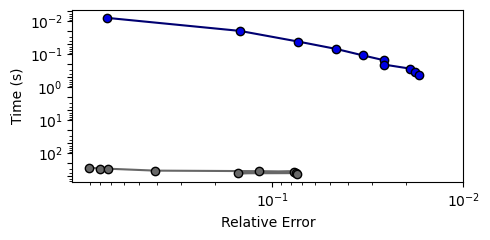

In [4]:
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, FixedLocator, FixedFormatter

# --- BEM data ---
bem_rel_error = [7.359e-01, 1.480e-01, 7.301e-02, 4.633e-02, 3.341e-02,
                 2.597e-02, 2.597e-02, 1.904e-02, 1.792e-02, 1.699e-02]
bem_time = [0.0078, 0.0194, 0.0410, 0.0684, 0.1079, 0.1510, 0.2040, 0.2700, 0.3460, 0.4260]

# --- PINN data ---
pinn_rel_error = [9.10e-01, 7.98e-01, 7.26e-01, 4.10e-01, 1.17e-01,
                  7.72e-02, 1.52e-01, 7.55e-02, 7.46e-02]
pinn_time = [268.5808, 287.7863, 291.1042, 333.6271, 346.1852,
             356.2399, 401.7561, 396.7530, 430.8179]

# --- Plot ---
plt.figure(figsize=(5.0, 2.5))

# BEM curve
plt.plot(bem_rel_error, bem_time, '-', color='#000071ff')
plt.scatter(bem_rel_error, bem_time, color='#0000e5ff', edgecolors='black', zorder=5)

# PINN curve
plt.plot(pinn_rel_error, pinn_time, '-', color='#676767ff')
plt.scatter(pinn_rel_error, pinn_time, color='#676767ff', edgecolors='black', zorder=5)

# Axes labels
plt.xlabel('Relative Error', fontsize=10)
plt.ylabel('Time (s)', fontsize=10)

# Log-log scale
plt.xscale('log')
plt.yscale('log')

# Invert both axes
ax = plt.gca()
ax.invert_xaxis()
ax.invert_yaxis()

# Add custom ticks for x-axis to ensure 1e-2 is visible and labeled
x_ticks = [1e-1, 1e-2]
ax.set_xticks(x_ticks)
ax.set_xticklabels([r'$10^{-1}$', r'$10^{-2}$'])

# Keep log ticks on y-axis
ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=(1.0, 2.0, 5.0), numticks=10))

# Save figure
plt.tight_layout()
plt.savefig("rel_error_time.svg", dpi=150, bbox_inches='tight')
plt.show()
